In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import torch.nn as nn

import sys
import os
sys.path.append(os.path.dirname('./ml/metrics'))
from metrics import (IOU_Metric, DiscriminatorLoss, GeneratorLoss,
                     SSIM3D, soft_dice_cldice, CycleLoss)

from metrics import (DICE_Metric, JAC_Metric, SN_Metric, SP_Metric)

In [3]:
import numpy as np
import matplotlib.pyplot as plt

img_real = torch.tensor( [[[[8*[0,],
                  8*[0,],
                  8*[0,],
                  8*[0,],
                  8*[0,],
                  8*[1,],
                  8*[1,],
                  8*[0,]]]]])
#plt.imshow(img_real[0,0,0])

In [4]:
img_fake = torch.tensor( [[[[8*[0,],
                  8*[0,],
                  8*[0,],
                  8*[0,],
                  8*[1,],
                  8*[1,],
                  8*[0,],
                  8*[0,]]]]])
#plt.imshow(img_fake[0,0,0])

In [5]:
m = IOU_Metric()
print(m(img_real, img_fake))
m = JAC_Metric()
print(m(img_real, img_fake))
m = DICE_Metric()
print(m(img_real, img_fake))
m = SN_Metric()
print(m(img_real, img_fake))
m = SP_Metric()
print(m(img_real, img_fake))


tensor([0.3333])
tensor([0.3333])
tensor([0.5000])
tensor([0.5000])
tensor([0.8333])


In [20]:
a = CycleLoss("tversky")
print(a(torch.tensor(img_real), torch.tensor(img_fake)))
b = CycleLoss("ssim")
#b = SSIM3D()
print(b(torch.tensor(img_real), torch.tensor(img_fake)))


tensor(0.9624)
tensor(0.8563)


In [4]:
img1 = torch.rand(1, 1, 64, 64, 64)
img2 = torch.rand(1, 1, 64, 64, 64)


In [6]:
print((img1/img2).shape)

torch.Size([1, 1, 64, 64, 64])


In [68]:
l = soft_cldice()
print(l(img1, img2))
print(l(img1, img1))
print(l(torch.sigmoid(img1), torch.sigmoid(img2)))
print(l(torch.sigmoid(img1), torch.sigmoid(img1)))

skel_pred.sum(): tensor(57384.9570)
skel_true.sum(): tensor(57590.5156)
tensor(0.5003)
skel_pred.sum(): tensor(57590.5156)
skel_true.sum(): tensor(57590.5156)
tensor(0.2541)
skel_pred.sum(): tensor(13837.1357)
skel_true.sum(): tensor(13886.5166)
tensor(0.3799)
skel_pred.sum(): tensor(13886.5166)
skel_true.sum(): tensor(13886.5166)
tensor(0.3240)


In [1]:
import numpy as np
import nibabel as nib
import sys
import os
from time import time, sleep
from scipy.ndimage import zoom
import matplotlib.pyplot as plt
import torchio as tio
import torch

sys.path.append(os.path.dirname('../.'))
from scripts.euclidian_map import euclidian_map, EDM_norm
from scripts.load_and_save import (get_dcm_info, get_dcm_vol, vox_size2affine,
                                   load_nii_vol, save_vol_as_nii, raw2nifti)

In [2]:
sample_name = "IXI200-Guys-0812-T1.nii.gz"
path_to_nii_file = "/home/msst/IXI-MRT/T1/" + sample_name
path_to_save = "/home/msst/IXI-MRT/converted/" + sample_name

image = tio.ScalarImage(path_to_nii_file)

transforms = [tio.transforms.ToCanonical(),
              tio.Resample(0.5)]
transform = tio.Compose(transforms)
image = transform(image)
image.save(path_to_save)

In [32]:
path_to_vessels = "/home/msst/Documents/medtech/data/Synthetic/seg/1.nii.gz"
path_to_sample = "/home/msst/IXI-MRT/converted/IXI200-Guys-0812-T1.nii.gz"

sample_image = tio.ScalarImage(path_to_sample)
head_vol = sample_image.data[0]
vessels_vol = load_nii_vol(path_to_vessels, np.int16)[0]

print(head_vol.shape)
print(vessels_vol.shape)

torch.Size([360, 481, 480])
(325, 304, 600)


In [33]:
vessels_vol = np.transpose(vessels_vol, [1, 2, 0])
print(vessels_vol.shape)

(304, 600, 325)


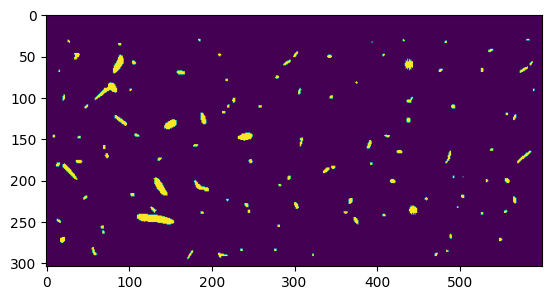

In [34]:
plt.imshow(vessels_vol[:, :, 100])

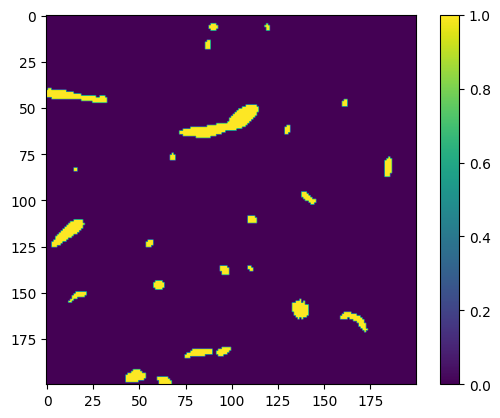

In [38]:
vessels_vol_cut = vessels_vol[50:250, 300:500, 50:150]
plt.imshow(vessels_vol_cut[:, :, 90])
plt.colorbar()

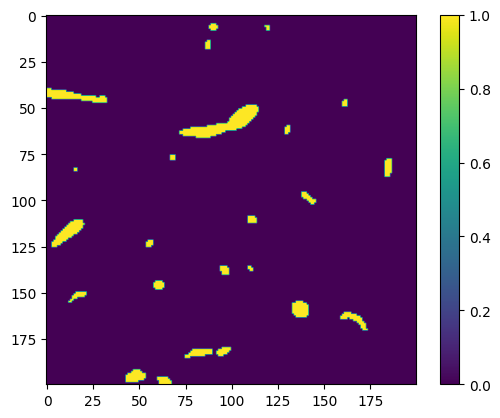

In [39]:
from torchvision.transforms import GaussianBlur
vessels_vol_cut = GaussianBlur(3, 1)(torch.tensor(vessels_vol_cut)).numpy()
plt.imshow(vessels_vol_cut[:, :, 90])
plt.colorbar()

In [40]:
save_vol_as_nii(vessels_vol_cut, sample_image.affine, '/home/msst/test_vessels.nii.gz')

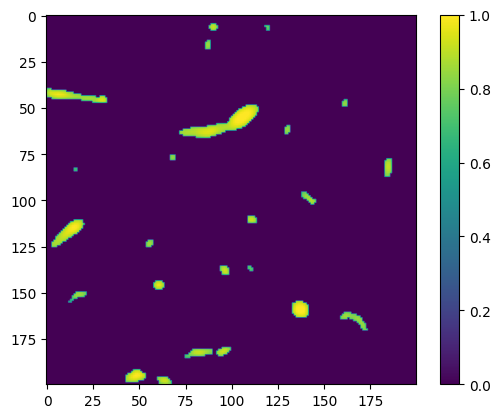

In [37]:
vessels_vol_cut = euclidian_map(vessels_vol_cut, 2)
vessels_vol_cut = EDM_norm(vessels_vol_cut)

plt.imshow(vessels_vol_cut[:, :, 90])
plt.colorbar()

In [8]:
tmp = 1*vessels_vol_cut
print("vessels max:", tmp.max())
tmp[tmp==0]=np.inf
print("vessels min:", tmp.min())
ves_min = tmp.min()

vessels max: 1.0
vessels min: 0.5034604364902124


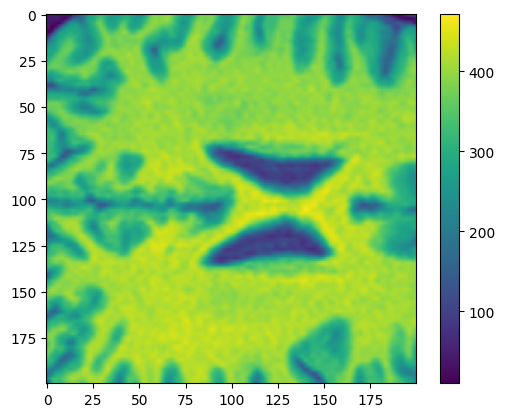

In [9]:
head_vol_cut = head_vol[75:275, 125:325, 250:350]
plt.imshow(head_vol_cut[:, :, 90])
plt.colorbar()

In [10]:
M = head_vol_cut.sum()/(200*200*100)
print(M)
M /= ves_min
print(M)

tensor(327.3292)
tensor(650.1588)


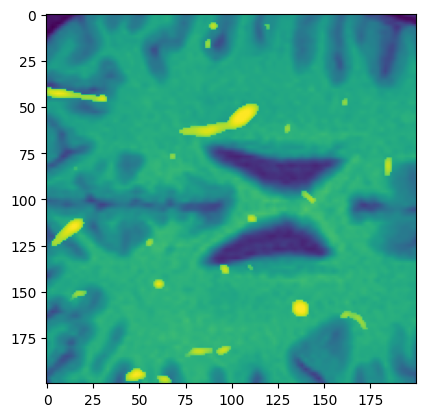

In [11]:
ves_brain = np.where(vessels_vol_cut>0, M*vessels_vol_cut, head_vol_cut)
plt.imshow(ves_brain[:, :, 90])

In [12]:
save_vol_as_nii(ves_brain, sample_image.affine, '/home/msst/test.nii.gz')

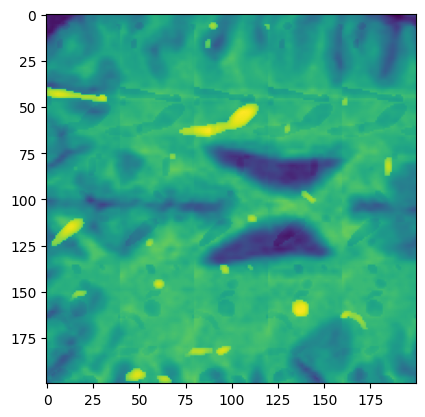

In [17]:
noised = tio.transforms.RandomGhosting(num_ghosts= (5), axes= (0, 1, 2),
                                     intensity = (1, 1), restore= 0.5)(torch.tensor([ves_brain]))
plt.imshow(noised[0, :, :, 90])

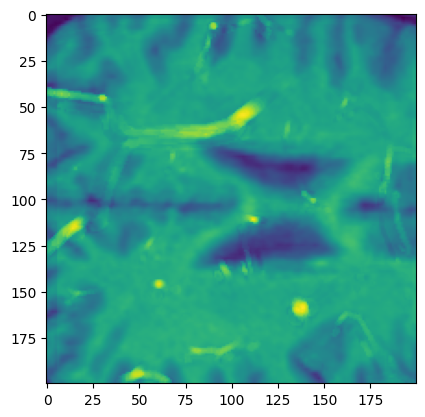

In [18]:
noised = tio.transforms.RandomMotion(degrees=0, translation=7,
                                     num_transforms=2, image_interpolation='linear')(torch.tensor([ves_brain]))
plt.imshow(noised[0, :, :, 90])

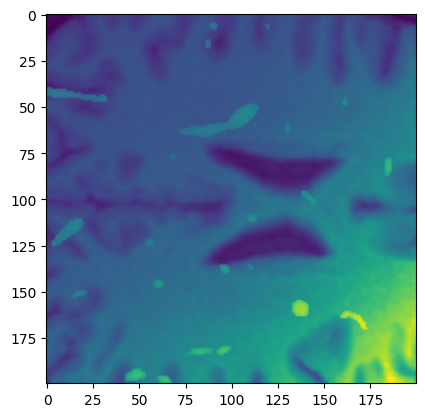

In [19]:
coef = 0.2
order = 2
noised = tio.transforms.RandomBiasField(coefficients=(coef, coef), order=order)(torch.tensor([ves_brain]))
plt.imshow(noised[0, :, :, 90])

In [20]:
def apply_smart_gauss_noise(vol, sigma_coef=0.02):
    sizes = np.array(vol.shape)
    new_vol = 1*vol
    for x in range(sizes[0]):
        for y in range(sizes[1]):
            for z in range(sizes[2]):
                new_vol[x, y, z] = vol[x, y, z] + np.random.normal(0, sigma_coef*vol[x, y, z])
    return(new_vol)

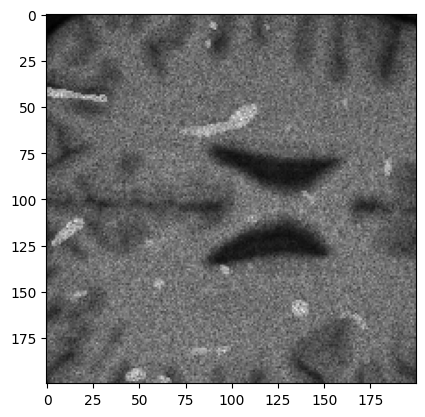

In [22]:
noised = apply_smart_gauss_noise(ves_brain, sigma_coef=0.15)
plt.imshow(noised[:, :, 90],cmap="gray")